 # Electrical Demand Forecasting
 
 ## LSTM Recurrant Neural Network Modeling

### 1. Import Modules <a id='import'></a>

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from dateutil import parser


import torch
import torch.nn as nn

%matplotlib inline

#### 2. Read the datafile and adjust

In [2]:
data_file = '../data/big_demand_temp_train.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)
dt_index = [parser.isoparse(x) for x in full_df.index]
full_df.index = dt_index
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,0,0,1,0,0,0,0,2
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,0,0,1,0,0,0,0,2
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,0,0,1,0,0,0,0,2
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,0,0,1,0,0,0,0,2
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,0,0,1,0,0,0,0,2


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
demand_normalized = scaler.fit_transform(np.array(full_df['demand']).reshape(-1,1))
full_df['demand'] = demand_normalized

In [7]:
# Split the data frame into two parts
data_len = full_df.shape[0]
train_len = int(0.5 * data_len)
window_len = int(0.1 * data_len)
validation_len = int(0.8 * data_len)

In [8]:
# Make the primary train/validation split
X_train = full_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = full_df.iloc[train_len:train_len+window_len, :]
X_walk2 = full_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = full_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

#### 3. Determine the configuration for the Neural Net and shape the input data

We would like to predict the electricity demand as far out as possible.  We saw that the SARIMAX model performance began to deteriorate after 3-ish weeks.  Given that weather forecasts (and therefore exogenous data) are roughly accurate for 2 weeks we'll try to get a 2 week estimate from our model.

For inputs we will start by using 6 weeks of prior data to to get a 2 week estimate.  So, for our model:

    inputs = 24 hours * 7 days * 6 weeks * 14 features
           = 14112
           
    outputs = 24 hours * 7 days * 2 weeks = 336
    
For hidden layers we'll start with 1 layer of 3000 nodes

In [9]:
def choose_train_data_block(X, start, in_size, out_size, step_size) :
    head = start+in_size+out_size
    tail = start
    while(head < len(X)) :
        # Implement this as a generator so we don't have to keep all the data in memory
        model_inputs = X[tail:tail+in_size]
        actual_y = X[tail+in_size:tail+in_size+out_size]
        
        head += step_size
        tail += step_size
        
        # Return a tuple of input values for 6 weeks and output values for 2 weeks.
        yield [model_inputs, actual_y]
    

In [51]:
seq = choose_train_data_block(X_train, 0, 168, 168, 168)

In [123]:
data = next(seq)

In [124]:
df_demand = pd.DataFrame(data[0])
df_demand

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,Mon,Tue,Wed,Thur,Fri,Sat,Sun,DOW
2015-07-22 08:00:00+00:00,0.041633,71.00,71.62,63.06,60.83,65.24,79.02,0,0,1,0,0,0,0,2
2015-07-22 09:00:00+00:00,-0.033983,70.79,71.42,62.47,60.60,64.28,77.40,0,0,1,0,0,0,0,2
2015-07-22 10:00:00+00:00,-0.089336,70.21,71.16,61.92,60.51,64.00,76.73,0,0,1,0,0,0,0,2
2015-07-22 11:00:00+00:00,-0.125002,69.75,71.25,61.10,60.31,63.36,75.23,0,0,1,0,0,0,0,2
2015-07-22 12:00:00+00:00,-0.136120,69.55,71.33,60.12,60.13,63.00,73.94,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-29 03:00:00+00:00,0.561566,74.61,69.03,84.34,71.62,96.69,95.84,0,0,1,0,0,0,0,2
2015-07-29 04:00:00+00:00,0.506078,72.19,68.42,80.11,71.39,89.33,91.17,0,0,1,0,0,0,0,2
2015-07-29 05:00:00+00:00,0.457899,70.79,68.01,77.11,67.92,83.26,88.24,0,0,1,0,0,0,0,2
2015-07-29 06:00:00+00:00,0.357700,69.73,67.83,74.58,66.34,80.07,84.89,0,0,1,0,0,0,0,2


In [80]:
win_demand = df_demand['demand'].values
len(win_demand)

168

In [122]:
coeffs = np.fft.rfft(win_demand)
coeffs[:10]

array([22.86829981 +0.j        ,  5.22622718 +0.56732256j,
       -4.25057575 +5.9670275j , -0.29286994 -2.02101178j,
       -1.17551137 +0.64146177j,  2.53505148 -0.38967529j,
       -1.6051477  +1.78142517j, -8.10685934+22.77716853j,
       -0.53629167 +0.82502445j, -0.17111335 -1.57975736j])

In [67]:
amps = [np.absolute(x) for x in coeffs]

In [131]:
big_coeffs = coeffs[:85]
len(big_coeffs)

85

In [132]:
rebuilt = np.fft.irfft(big_coeffs)

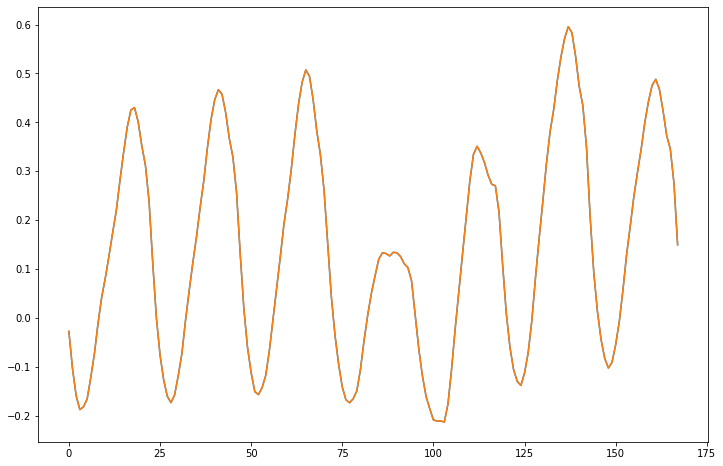

In [133]:
fig = plt.figure(figsize=[12,8])
plt.plot(win_demand)
plt.plot(rebuilt)

Build a data frame with FFT coefficients for each week

In [160]:
coef_names = [('r'+str(x), 'i'+str(x)) for x in range(85)]
col_names = []
for i in range(len(coef_names)) :
    col_names.append(coef_names[i][0])
    col_names.append(coef_names[i][1])

In [168]:
coef_df = pd.DataFrame(columns=col_names)
for week_data in choose_train_data_block(X_train, 0, 168, 168, 168) :
    week_df = pd.DataFrame(week_data[0])
    week_demand = week_df['demand'].values
    week_date = week_df.index[0]
    week_coeffs = np.fft.rfft(week_demand)
    split_coeffs = []
    for coef in week_coeffs[:85] :
        split_coeffs.append(coef.real)
        split_coeffs.append(coef.imag)
    coef_df.loc[week_date] = split_coeffs

In [169]:
coef_df

,r0,i0,r1,i1,r2,i2,r3,i3,r4,i4,...,r80,i80,r81,i81,r82,i82,r83,i83,r84,i84
2015-07-01 08:00:00+00:00,19.290822,0.0,6.102485,-7.556183,-0.885397,-0.604030,-1.923180,-1.912638,0.921761,-1.478098,...,0.097674,-0.006379,0.120106,0.002558,0.129182,0.016945,0.118368,-0.010639,0.076841,0.0
2015-07-08 08:00:00+00:00,5.702225,0.0,5.752552,2.211769,-0.468495,3.612363,-1.020060,-0.368116,0.323727,-0.923760,...,0.058093,0.041486,-0.020324,0.052426,-0.035495,0.032586,-0.050849,0.006183,-0.055931,0.0
2015-07-15 08:00:00+00:00,22.868300,0.0,5.226227,0.567323,-4.250576,5.967027,-0.292870,-2.021012,-1.175511,0.641462,...,-0.026301,0.004742,-0.035185,0.002195,-0.045699,0.024986,-0.009743,0.017399,-0.027438,0.0
2015-07-22 08:00:00+00:00,19.884569,0.0,5.170554,-1.318418,2.054066,3.799137,0.180105,0.120582,1.093316,-0.564322,...,-0.081553,-0.061330,-0.025475,0.077957,0.017212,-0.076196,-0.111963,0.064630,0.074087,0.0
2015-07-29 08:00:00+00:00,30.773065,0.0,3.821303,-7.531259,-2.264614,1.339447,-1.043550,-2.183801,-0.554037,-1.732535,...,0.007504,0.014459,0.032266,-0.015071,0.005797,-0.006154,0.039225,-0.014988,-0.015572,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-29 08:00:00+00:00,-31.266545,0.0,4.520839,-1.982917,-0.868561,1.694477,-0.248204,-0.887174,0.382085,-0.534528,...,0.033909,0.030625,0.003870,-0.014676,-0.022059,0.004047,-0.043437,0.025506,0.001768,0.0
2017-04-05 08:00:00+00:00,-28.219098,0.0,4.901080,-4.199251,-1.026059,2.359160,-1.072360,-0.663686,0.022495,-0.594660,...,-0.008236,0.008128,-0.014956,-0.020036,0.004479,0.015919,-0.024411,-0.021609,-0.005440,0.0
2017-04-12 08:00:00+00:00,-27.700287,0.0,5.588656,-0.468940,-1.242782,2.223188,-1.434452,-0.255997,0.155604,-0.696178,...,0.010051,-0.003586,-0.026200,-0.017363,0.011647,0.000704,0.010625,-0.017407,-0.032130,0.0
2017-04-19 08:00:00+00:00,-22.116791,0.0,0.949136,-2.130405,-0.086499,2.331993,-1.050466,-1.528996,0.592731,-1.157028,...,0.048785,-0.024739,0.027544,0.009241,0.013689,-0.000848,0.021579,0.008573,0.097445,0.0


In [170]:
torch.tensor(coef_df[:].values)

tensor([[ 1.9291e+01,  0.0000e+00,  6.1025e+00,  ..., -1.0639e-02,
          7.6841e-02,  0.0000e+00],
        [ 5.7022e+00,  0.0000e+00,  5.7526e+00,  ...,  6.1835e-03,
         -5.5931e-02,  0.0000e+00],
        [ 2.2868e+01,  0.0000e+00,  5.2262e+00,  ...,  1.7399e-02,
         -2.7438e-02,  0.0000e+00],
        ...,
        [-2.7700e+01,  0.0000e+00,  5.5887e+00,  ..., -1.7407e-02,
         -3.2130e-02,  0.0000e+00],
        [-2.2117e+01,  0.0000e+00,  9.4914e-01,  ...,  8.5734e-03,
          9.7445e-02,  0.0000e+00],
        [-1.6777e+01,  0.0000e+00,  6.3155e+00,  ...,  2.1539e-02,
         -3.7400e-03,  0.0000e+00]], dtype=torch.float64)